In [1]:
!python -m pip install pyyaml
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="wGAwqiSzpTtVb7CdetNz")
project = rf.workspace("yolodec").project("miliraty")
version = project.version(1)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/kaggle/working/miliraty-1/train/_annotations.coco.json", "/kaggle/working/miliraty-1/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/working/miliraty-1/valid/_annotations.coco.json", "/kaggle/working/miliraty-1/valid")
register_coco_instances("my_dataset_test", {}, "/kaggle/working/miliraty-1/test/_annotations.coco.json", "/kaggle/working/miliraty-1/test")

In [4]:
import matplotlib.pyplot as plt

WARNING [06/19 13:35:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/19 13:35:30 d2.data.datasets.coco]: Loaded 1318 images in COCO format from /kaggle/working/miliraty-1/train/_annotations.coco.json


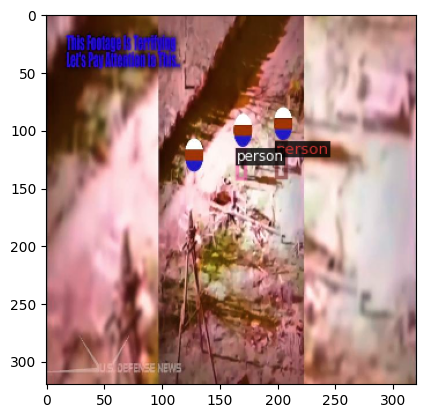

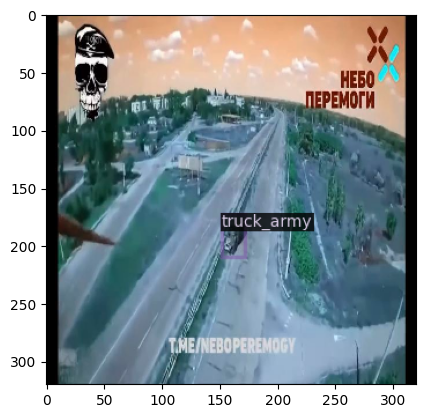

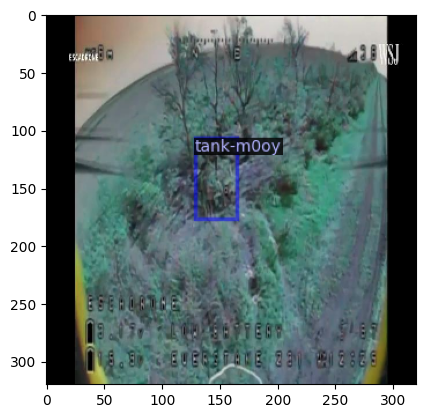

In [5]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata = my_dataset_train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder='/kaggle/working'):

    if output_folder is None:
      os.makedirs("coco_eval", exist_ok=True)
      output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
from detectron2.modeling.backbone import BACKBONE_REGISTRY
from detectron2.config import get_cfg
from detectron2.modeling import Backbone

import os

import torch.nn as nn
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.modeling.backbone import Backbone
from detectron2.data.datasets import register_coco_instances
from detectron2.modeling import BACKBONE_REGISTRY
from detectron2.layers import ShapeSpec
import torch.nn as nn

cfg = get_cfg()
cfg.merge_from_file("/kaggle/working/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.MODEL.WEIGHTS = ("/kaggle/working/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo


cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 2000
cfg.SOLVER.MAX_ITER = 30000 # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = (10000, 15000)        # do not decay learning rate
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.TEST.EVAL_PERIOD = 1000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.train()

[06/19 13:47:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 13:47:29 d2.utils.events]:  eta: 5:33:27  iter: 19  total_loss: 47.09  loss_cls: 45.33  loss_box_reg: 0.6515  loss_rpn_cls: 1.239  loss_rpn_loc: 1.267    time: 0.6384  last_time: 0.6743  data_time: 0.0289  last_data_time: 0.0105   lr: 1.0491e-05  max_mem: 5779M
[06/19 13:47:41 d2.utils.events]:  eta: 5:33:01  iter: 39  total_loss: 8.543  loss_cls: 7.961  loss_box_reg: 0.1569  loss_rpn_cls: 0.2046  loss_rpn_loc: 0.1422    time: 0.6310  last_time: 0.6805  data_time: 0.0143  last_data_time: 0.0121   lr: 2.048e-05  max_mem: 5779M
[06/19 13:47:54 d2.utils.events]:  eta: 5:32:48  iter: 59  total_loss: 2.161  loss_cls: 1.867  loss_box_reg: 0.07763  loss_rpn_cls: 0.1453  loss_rpn_loc: 0.07946    time: 0.6351  last_time: 0.6916  data_time: 0.0135  last_data_time: 0.0190   lr: 3.047e-05  max_mem: 5779M
[06/19 13:48:07 d2.utils.events]:  eta: 5:32:34  iter: 79  total_loss: 1.026  loss_cls: 0.5947  loss_box_reg: 0.1369  loss_rpn_cls: 0.1399  loss_rpn_loc: 0.06984    time: 0.6346  last_time:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 13:57:55 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0013 s/iter. Inference: 0.0870 s/iter. Eval: 0.0004 s/iter. Total: 0.0887 s/iter. ETA=0:00:32
[06/19 13:58:00 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0017 s/iter. Inference: 0.0838 s/iter. Eval: 0.0004 s/iter. Total: 0.0861 s/iter. ETA=0:00:26
[06/19 13:58:05 d2.evaluation.evaluator]: Inference done 129/376. Dataloading: 0.0017 s/iter. Inference: 0.0836 s/iter. Eval: 0.0004 s/iter. Total: 0.0859 s/iter. ETA=0:00:21
[06/19 13:58:10 d2.evaluation.evaluator]: Inference done 188/376. Dataloading: 0.0018 s/iter. Inference: 0.0836 s/iter. Eval: 0.0004 s/iter. Total: 0.0858 s/iter. ETA=0:00:16
[06/19 13:58:16 d2.evaluation.evaluator]: Inference done 247/376. Dataloading: 0.0018 s/iter. Inference: 0.0835 s/iter. Eval: 0.0004 s/iter. Total: 0.0857 s/iter. ETA=0:00:11
[06/19 13:58:21 d2.evaluation.evaluator]: Inference done 306/376. Dataloading: 0.0018 s/iter. Inference: 0.0835 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 13:58:27 d2.evaluation.evaluator]: Total inference time: 0:00:31.865161 (0.085890 s / iter per device, on 1 devices)
[06/19 13:58:27 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.083464 s / iter per device, on 1 devices)
[06/19 13:58:27 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 13:58:27 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 13:58:27 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.07s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:09:09 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0010 s/iter. Inference: 0.0845 s/iter. Eval: 0.0005 s/iter. Total: 0.0860 s/iter. ETA=0:00:31
[06/19 14:09:14 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0017 s/iter. Inference: 0.0831 s/iter. Eval: 0.0005 s/iter. Total: 0.0854 s/iter. ETA=0:00:26
[06/19 14:09:19 d2.evaluation.evaluator]: Inference done 129/376. Dataloading: 0.0018 s/iter. Inference: 0.0832 s/iter. Eval: 0.0005 s/iter. Total: 0.0855 s/iter. ETA=0:00:21
[06/19 14:09:24 d2.evaluation.evaluator]: Inference done 188/376. Dataloading: 0.0018 s/iter. Inference: 0.0832 s/iter. Eval: 0.0005 s/iter. Total: 0.0855 s/iter. ETA=0:00:16
[06/19 14:09:29 d2.evaluation.evaluator]: Inference done 247/376. Dataloading: 0.0018 s/iter. Inference: 0.0832 s/iter. Eval: 0.0005 s/iter. Total: 0.0855 s/iter. ETA=0:00:11
[06/19 14:09:34 d2.evaluation.evaluator]: Inference done 306/376. Dataloading: 0.0018 s/iter. Inference: 0.0831 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:09:40 d2.evaluation.evaluator]: Total inference time: 0:00:31.802397 (0.085721 s / iter per device, on 1 devices)
[06/19 14:09:40 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.083158 s / iter per device, on 1 devices)
[06/19 14:09:41 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 14:09:41 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 14:09:41 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:20:19 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0014 s/iter. Inference: 0.0842 s/iter. Eval: 0.0006 s/iter. Total: 0.0861 s/iter. ETA=0:00:31
[06/19 14:20:24 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0005 s/iter. Total: 0.0851 s/iter. ETA=0:00:26
[06/19 14:20:29 d2.evaluation.evaluator]: Inference done 129/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0005 s/iter. Total: 0.0851 s/iter. ETA=0:00:21
[06/19 14:20:34 d2.evaluation.evaluator]: Inference done 189/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0.0005 s/iter. Total: 0.0849 s/iter. ETA=0:00:15
[06/19 14:20:39 d2.evaluation.evaluator]: Inference done 249/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0.0005 s/iter. Total: 0.0848 s/iter. ETA=0:00:10
[06/19 14:20:45 d2.evaluation.evaluator]: Inference done 309/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:20:50 d2.evaluation.evaluator]: Total inference time: 0:00:31.493035 (0.084887 s / iter per device, on 1 devices)
[06/19 14:20:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082400 s / iter per device, on 1 devices)
[06/19 14:20:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 14:20:51 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 14:20:51 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.30s).
Accumulating evaluation results...
DONE (t=0.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:31:28 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0013 s/iter. Inference: 0.0843 s/iter. Eval: 0.0006 s/iter. Total: 0.0862 s/iter. ETA=0:00:31
[06/19 14:31:33 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0017 s/iter. Inference: 0.0832 s/iter. Eval: 0.0005 s/iter. Total: 0.0855 s/iter. ETA=0:00:26
[06/19 14:31:38 d2.evaluation.evaluator]: Inference done 129/376. Dataloading: 0.0017 s/iter. Inference: 0.0831 s/iter. Eval: 0.0005 s/iter. Total: 0.0855 s/iter. ETA=0:00:21
[06/19 14:31:43 d2.evaluation.evaluator]: Inference done 188/376. Dataloading: 0.0017 s/iter. Inference: 0.0831 s/iter. Eval: 0.0005 s/iter. Total: 0.0854 s/iter. ETA=0:00:16
[06/19 14:31:48 d2.evaluation.evaluator]: Inference done 247/376. Dataloading: 0.0017 s/iter. Inference: 0.0830 s/iter. Eval: 0.0005 s/iter. Total: 0.0853 s/iter. ETA=0:00:11
[06/19 14:31:53 d2.evaluation.evaluator]: Inference done 301/376. Dataloading: 0.0017 s/iter. Inference: 0.0830 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:31:59 d2.evaluation.evaluator]: Total inference time: 0:00:32.216941 (0.086838 s / iter per device, on 1 devices)
[06/19 14:31:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.083018 s / iter per device, on 1 devices)
[06/19 14:32:00 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 14:32:00 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 14:32:00 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.30s).
Accumulating evaluation results...
DONE (t=0.71s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:42:39 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0013 s/iter. Inference: 0.0859 s/iter. Eval: 0.0005 s/iter. Total: 0.0877 s/iter. ETA=0:00:32
[06/19 14:42:44 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0017 s/iter. Inference: 0.0830 s/iter. Eval: 0.0005 s/iter. Total: 0.0853 s/iter. ETA=0:00:26
[06/19 14:42:49 d2.evaluation.evaluator]: Inference done 129/376. Dataloading: 0.0017 s/iter. Inference: 0.0829 s/iter. Eval: 0.0005 s/iter. Total: 0.0853 s/iter. ETA=0:00:21
[06/19 14:42:54 d2.evaluation.evaluator]: Inference done 188/376. Dataloading: 0.0018 s/iter. Inference: 0.0830 s/iter. Eval: 0.0005 s/iter. Total: 0.0854 s/iter. ETA=0:00:16
[06/19 14:42:59 d2.evaluation.evaluator]: Inference done 247/376. Dataloading: 0.0018 s/iter. Inference: 0.0829 s/iter. Eval: 0.0005 s/iter. Total: 0.0853 s/iter. ETA=0:00:11
[06/19 14:43:04 d2.evaluation.evaluator]: Inference done 306/376. Dataloading: 0.0018 s/iter. Inference: 0.0829 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:43:10 d2.evaluation.evaluator]: Total inference time: 0:00:31.700767 (0.085447 s / iter per device, on 1 devices)
[06/19 14:43:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082923 s / iter per device, on 1 devices)
[06/19 14:43:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 14:43:11 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 14:43:11 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.47s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.24s).
Accumulating evaluation results...
DONE (t=0.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:53:49 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0015 s/iter. Inference: 0.0833 s/iter. Eval: 0.0005 s/iter. Total: 0.0853 s/iter. ETA=0:00:31
[06/19 14:53:54 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0017 s/iter. Inference: 0.0822 s/iter. Eval: 0.0005 s/iter. Total: 0.0845 s/iter. ETA=0:00:25
[06/19 14:53:59 d2.evaluation.evaluator]: Inference done 130/376. Dataloading: 0.0018 s/iter. Inference: 0.0822 s/iter. Eval: 0.0005 s/iter. Total: 0.0846 s/iter. ETA=0:00:20
[06/19 14:54:04 d2.evaluation.evaluator]: Inference done 190/376. Dataloading: 0.0018 s/iter. Inference: 0.0823 s/iter. Eval: 0.0005 s/iter. Total: 0.0846 s/iter. ETA=0:00:15
[06/19 14:54:10 d2.evaluation.evaluator]: Inference done 250/376. Dataloading: 0.0018 s/iter. Inference: 0.0822 s/iter. Eval: 0.0005 s/iter. Total: 0.0845 s/iter. ETA=0:00:10
[06/19 14:54:15 d2.evaluation.evaluator]: Inference done 310/376. Dataloading: 0.0018 s/iter. Inference: 0.0822 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 14:54:20 d2.evaluation.evaluator]: Total inference time: 0:00:31.387611 (0.084603 s / iter per device, on 1 devices)
[06/19 14:54:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082142 s / iter per device, on 1 devices)
[06/19 14:54:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 14:54:21 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 14:54:21 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.12s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:05:00 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0015 s/iter. Inference: 0.0845 s/iter. Eval: 0.0005 s/iter. Total: 0.0866 s/iter. ETA=0:00:31
[06/19 15:05:05 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0005 s/iter. Total: 0.0851 s/iter. ETA=0:00:26
[06/19 15:05:10 d2.evaluation.evaluator]: Inference done 123/376. Dataloading: 0.0018 s/iter. Inference: 0.0828 s/iter. Eval: 0.0047 s/iter. Total: 0.0894 s/iter. ETA=0:00:22
[06/19 15:05:15 d2.evaluation.evaluator]: Inference done 182/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0033 s/iter. Total: 0.0879 s/iter. ETA=0:00:17
[06/19 15:05:20 d2.evaluation.evaluator]: Inference done 241/376. Dataloading: 0.0018 s/iter. Inference: 0.0826 s/iter. Eval: 0.0026 s/iter. Total: 0.0871 s/iter. ETA=0:00:11
[06/19 15:05:25 d2.evaluation.evaluator]: Inference done 301/376. Dataloading: 0.0018 s/iter. Inference: 0.0826 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:05:31 d2.evaluation.evaluator]: Total inference time: 0:00:32.092243 (0.086502 s / iter per device, on 1 devices)
[06/19 15:05:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082627 s / iter per device, on 1 devices)
[06/19 15:05:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 15:05:32 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 15:05:32 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.04s).
Accumulating evaluation results...
DONE (t=0.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.012
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:16:10 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0013 s/iter. Inference: 0.0837 s/iter. Eval: 0.0007 s/iter. Total: 0.0857 s/iter. ETA=0:00:31
[06/19 15:16:15 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0017 s/iter. Inference: 0.0824 s/iter. Eval: 0.0005 s/iter. Total: 0.0847 s/iter. ETA=0:00:25
[06/19 15:16:20 d2.evaluation.evaluator]: Inference done 131/376. Dataloading: 0.0018 s/iter. Inference: 0.0823 s/iter. Eval: 0.0005 s/iter. Total: 0.0847 s/iter. ETA=0:00:20
[06/19 15:16:25 d2.evaluation.evaluator]: Inference done 190/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0005 s/iter. Total: 0.0848 s/iter. ETA=0:00:15
[06/19 15:16:31 d2.evaluation.evaluator]: Inference done 250/376. Dataloading: 0.0018 s/iter. Inference: 0.0823 s/iter. Eval: 0.0005 s/iter. Total: 0.0847 s/iter. ETA=0:00:10
[06/19 15:16:36 d2.evaluation.evaluator]: Inference done 310/376. Dataloading: 0.0019 s/iter. Inference: 0.0823 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:16:41 d2.evaluation.evaluator]: Total inference time: 0:00:31.485141 (0.084866 s / iter per device, on 1 devices)
[06/19 15:16:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082272 s / iter per device, on 1 devices)
[06/19 15:16:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 15:16:42 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 15:16:42 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.30s).
Accumulating evaluation results...
DONE (t=0.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:27:18 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0014 s/iter. Inference: 0.0822 s/iter. Eval: 0.0005 s/iter. Total: 0.0841 s/iter. ETA=0:00:30
[06/19 15:27:23 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0017 s/iter. Inference: 0.0820 s/iter. Eval: 0.0005 s/iter. Total: 0.0843 s/iter. ETA=0:00:25
[06/19 15:27:28 d2.evaluation.evaluator]: Inference done 130/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0005 s/iter. Total: 0.0848 s/iter. ETA=0:00:20
[06/19 15:27:33 d2.evaluation.evaluator]: Inference done 189/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0.0005 s/iter. Total: 0.0848 s/iter. ETA=0:00:15
[06/19 15:27:38 d2.evaluation.evaluator]: Inference done 248/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0.0005 s/iter. Total: 0.0848 s/iter. ETA=0:00:10
[06/19 15:27:43 d2.evaluation.evaluator]: Inference done 307/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:27:49 d2.evaluation.evaluator]: Total inference time: 0:00:31.557632 (0.085061 s / iter per device, on 1 devices)
[06/19 15:27:49 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082530 s / iter per device, on 1 devices)
[06/19 15:27:49 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 15:27:49 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 15:27:50 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.10s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.033
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:38:25 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0023 s/iter. Inference: 0.0868 s/iter. Eval: 0.0005 s/iter. Total: 0.0897 s/iter. ETA=0:00:32
[06/19 15:38:30 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0019 s/iter. Inference: 0.0830 s/iter. Eval: 0.0005 s/iter. Total: 0.0854 s/iter. ETA=0:00:26
[06/19 15:38:35 d2.evaluation.evaluator]: Inference done 129/376. Dataloading: 0.0019 s/iter. Inference: 0.0827 s/iter. Eval: 0.0005 s/iter. Total: 0.0852 s/iter. ETA=0:00:21
[06/19 15:38:40 d2.evaluation.evaluator]: Inference done 188/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0005 s/iter. Total: 0.0851 s/iter. ETA=0:00:15
[06/19 15:38:45 d2.evaluation.evaluator]: Inference done 247/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0005 s/iter. Total: 0.0850 s/iter. ETA=0:00:10
[06/19 15:38:50 d2.evaluation.evaluator]: Inference done 306/376. Dataloading: 0.0018 s/iter. Inference: 0.0826 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:38:57 d2.evaluation.evaluator]: Total inference time: 0:00:31.621830 (0.085234 s / iter per device, on 1 devices)
[06/19 15:38:57 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082677 s / iter per device, on 1 devices)
[06/19 15:38:57 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 15:38:57 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 15:38:57 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.96s).
Accumulating evaluation results...
DONE (t=0.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.040
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:49:35 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0012 s/iter. Inference: 0.0828 s/iter. Eval: 0.0005 s/iter. Total: 0.0845 s/iter. ETA=0:00:30
[06/19 15:49:40 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0018 s/iter. Inference: 0.0828 s/iter. Eval: 0.0005 s/iter. Total: 0.0851 s/iter. ETA=0:00:26
[06/19 15:49:45 d2.evaluation.evaluator]: Inference done 129/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0005 s/iter. Total: 0.0850 s/iter. ETA=0:00:20
[06/19 15:49:50 d2.evaluation.evaluator]: Inference done 188/376. Dataloading: 0.0018 s/iter. Inference: 0.0826 s/iter. Eval: 0.0005 s/iter. Total: 0.0850 s/iter. ETA=0:00:15
[06/19 15:49:55 d2.evaluation.evaluator]: Inference done 247/376. Dataloading: 0.0018 s/iter. Inference: 0.0826 s/iter. Eval: 0.0005 s/iter. Total: 0.0849 s/iter. ETA=0:00:10
[06/19 15:50:00 d2.evaluation.evaluator]: Inference done 306/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 15:50:06 d2.evaluation.evaluator]: Total inference time: 0:00:31.598962 (0.085172 s / iter per device, on 1 devices)
[06/19 15:50:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082674 s / iter per device, on 1 devices)
[06/19 15:50:07 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 15:50:07 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 15:50:07 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.46s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.81s).
Accumulating evaluation results...
DONE (t=0.54s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.089
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:00:43 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0010 s/iter. Inference: 0.0838 s/iter. Eval: 0.0005 s/iter. Total: 0.0853 s/iter. ETA=0:00:31
[06/19 16:00:48 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0017 s/iter. Inference: 0.0824 s/iter. Eval: 0.0005 s/iter. Total: 0.0848 s/iter. ETA=0:00:25
[06/19 16:00:53 d2.evaluation.evaluator]: Inference done 130/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0848 s/iter. ETA=0:00:20
[06/19 16:00:58 d2.evaluation.evaluator]: Inference done 189/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0.0004 s/iter. Total: 0.0848 s/iter. ETA=0:00:15
[06/19 16:01:03 d2.evaluation.evaluator]: Inference done 248/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0.0004 s/iter. Total: 0.0848 s/iter. ETA=0:00:10
[06/19 16:01:08 d2.evaluation.evaluator]: Inference done 307/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:01:14 d2.evaluation.evaluator]: Total inference time: 0:00:31.524147 (0.084971 s / iter per device, on 1 devices)
[06/19 16:01:14 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082490 s / iter per device, on 1 devices)
[06/19 16:01:14 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 16:01:14 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 16:01:14 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.74s).
Accumulating evaluation results...
DONE (t=0.54s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.090
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:11:52 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0012 s/iter. Inference: 0.0841 s/iter. Eval: 0.0005 s/iter. Total: 0.0858 s/iter. ETA=0:00:31
[06/19 16:11:57 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0018 s/iter. Inference: 0.0829 s/iter. Eval: 0.0004 s/iter. Total: 0.0852 s/iter. ETA=0:00:26
[06/19 16:12:02 d2.evaluation.evaluator]: Inference done 129/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0004 s/iter. Total: 0.0850 s/iter. ETA=0:00:21
[06/19 16:12:07 d2.evaluation.evaluator]: Inference done 188/376. Dataloading: 0.0018 s/iter. Inference: 0.0826 s/iter. Eval: 0.0004 s/iter. Total: 0.0850 s/iter. ETA=0:00:15
[06/19 16:12:12 d2.evaluation.evaluator]: Inference done 248/376. Dataloading: 0.0018 s/iter. Inference: 0.0826 s/iter. Eval: 0.0004 s/iter. Total: 0.0849 s/iter. ETA=0:00:10
[06/19 16:12:17 d2.evaluation.evaluator]: Inference done 307/376. Dataloading: 0.0018 s/iter. Inference: 0.0826 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:12:23 d2.evaluation.evaluator]: Total inference time: 0:00:32.047337 (0.086381 s / iter per device, on 1 devices)
[06/19 16:12:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082567 s / iter per device, on 1 devices)
[06/19 16:12:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 16:12:23 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 16:12:24 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.64s).
Accumulating evaluation results...
DONE (t=0.55s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.092
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:23:00 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0016 s/iter. Inference: 0.0834 s/iter. Eval: 0.0005 s/iter. Total: 0.0855 s/iter. ETA=0:00:31
[06/19 16:23:05 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0847 s/iter. ETA=0:00:25
[06/19 16:23:10 d2.evaluation.evaluator]: Inference done 131/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0847 s/iter. ETA=0:00:20
[06/19 16:23:15 d2.evaluation.evaluator]: Inference done 191/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0847 s/iter. ETA=0:00:15
[06/19 16:23:20 d2.evaluation.evaluator]: Inference done 251/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0847 s/iter. ETA=0:00:10
[06/19 16:23:25 d2.evaluation.evaluator]: Inference done 310/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:23:31 d2.evaluation.evaluator]: Total inference time: 0:00:31.502785 (0.084913 s / iter per device, on 1 devices)
[06/19 16:23:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082475 s / iter per device, on 1 devices)
[06/19 16:23:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 16:23:31 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 16:23:31 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.69s).
Accumulating evaluation results...
DONE (t=0.51s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.099
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:34:09 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0014 s/iter. Inference: 0.0848 s/iter. Eval: 0.0005 s/iter. Total: 0.0867 s/iter. ETA=0:00:31
[06/19 16:34:14 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0017 s/iter. Inference: 0.0825 s/iter. Eval: 0.0004 s/iter. Total: 0.0848 s/iter. ETA=0:00:25
[06/19 16:34:19 d2.evaluation.evaluator]: Inference done 130/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0004 s/iter. Total: 0.0849 s/iter. ETA=0:00:20
[06/19 16:34:24 d2.evaluation.evaluator]: Inference done 190/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0.0004 s/iter. Total: 0.0848 s/iter. ETA=0:00:15
[06/19 16:34:29 d2.evaluation.evaluator]: Inference done 249/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0.0004 s/iter. Total: 0.0848 s/iter. ETA=0:00:10
[06/19 16:34:35 d2.evaluation.evaluator]: Inference done 309/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:34:41 d2.evaluation.evaluator]: Total inference time: 0:00:32.069114 (0.086440 s / iter per device, on 1 devices)
[06/19 16:34:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:31 (0.083942 s / iter per device, on 1 devices)
[06/19 16:34:41 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 16:34:41 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 16:34:41 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.64s).
Accumulating evaluation results...
DONE (t=0.49s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.100
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:45:17 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0010 s/iter. Inference: 0.0845 s/iter. Eval: 0.0005 s/iter. Total: 0.0861 s/iter. ETA=0:00:31
[06/19 16:45:22 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0017 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0846 s/iter. ETA=0:00:25
[06/19 16:45:27 d2.evaluation.evaluator]: Inference done 130/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0847 s/iter. ETA=0:00:20
[06/19 16:45:32 d2.evaluation.evaluator]: Inference done 189/376. Dataloading: 0.0018 s/iter. Inference: 0.0825 s/iter. Eval: 0.0004 s/iter. Total: 0.0848 s/iter. ETA=0:00:15
[06/19 16:45:37 d2.evaluation.evaluator]: Inference done 249/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0847 s/iter. ETA=0:00:10
[06/19 16:45:42 d2.evaluation.evaluator]: Inference done 308/376. Dataloading: 0.0018 s/iter. Inference: 0.0824 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:45:48 d2.evaluation.evaluator]: Total inference time: 0:00:31.519618 (0.084959 s / iter per device, on 1 devices)
[06/19 16:45:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082527 s / iter per device, on 1 devices)
[06/19 16:45:48 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 16:45:48 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 16:45:48 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.65s).
Accumulating evaluation results...
DONE (t=0.51s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.096
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:56:26 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0013 s/iter. Inference: 0.0847 s/iter. Eval: 0.0005 s/iter. Total: 0.0866 s/iter. ETA=0:00:31
[06/19 16:56:31 d2.evaluation.evaluator]: Inference done 70/376. Dataloading: 0.0018 s/iter. Inference: 0.0829 s/iter. Eval: 0.0005 s/iter. Total: 0.0852 s/iter. ETA=0:00:26
[06/19 16:56:37 d2.evaluation.evaluator]: Inference done 129/376. Dataloading: 0.0018 s/iter. Inference: 0.0828 s/iter. Eval: 0.0004 s/iter. Total: 0.0852 s/iter. ETA=0:00:21
[06/19 16:56:42 d2.evaluation.evaluator]: Inference done 188/376. Dataloading: 0.0018 s/iter. Inference: 0.0828 s/iter. Eval: 0.0004 s/iter. Total: 0.0851 s/iter. ETA=0:00:16
[06/19 16:56:47 d2.evaluation.evaluator]: Inference done 241/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0.0026 s/iter. Total: 0.0872 s/iter. ETA=0:00:11
[06/19 16:56:52 d2.evaluation.evaluator]: Inference done 301/376. Dataloading: 0.0018 s/iter. Inference: 0.0827 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 16:56:58 d2.evaluation.evaluator]: Total inference time: 0:00:32.092095 (0.086502 s / iter per device, on 1 devices)
[06/19 16:56:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082619 s / iter per device, on 1 devices)
[06/19 16:56:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 16:56:58 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 16:56:58 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.72s).
Accumulating evaluation results...
DONE (t=0.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.089
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:07:35 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0012 s/iter. Inference: 0.0836 s/iter. Eval: 0.0005 s/iter. Total: 0.0854 s/iter. ETA=0:00:31
[06/19 17:07:40 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0017 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0846 s/iter. ETA=0:00:25
[06/19 17:07:45 d2.evaluation.evaluator]: Inference done 130/376. Dataloading: 0.0017 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0847 s/iter. ETA=0:00:20
[06/19 17:07:50 d2.evaluation.evaluator]: Inference done 190/376. Dataloading: 0.0017 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0846 s/iter. ETA=0:00:15
[06/19 17:07:55 d2.evaluation.evaluator]: Inference done 249/376. Dataloading: 0.0017 s/iter. Inference: 0.0825 s/iter. Eval: 0.0004 s/iter. Total: 0.0847 s/iter. ETA=0:00:10
[06/19 17:08:00 d2.evaluation.evaluator]: Inference done 308/376. Dataloading: 0.0018 s/iter. Inference: 0.0826 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:08:06 d2.evaluation.evaluator]: Total inference time: 0:00:31.566097 (0.085084 s / iter per device, on 1 devices)
[06/19 17:08:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082608 s / iter per device, on 1 devices)
[06/19 17:08:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 17:08:06 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 17:08:06 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.65s).
Accumulating evaluation results...
DONE (t=0.49s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.084
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:18:36 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0010 s/iter. Inference: 0.0817 s/iter. Eval: 0.0004 s/iter. Total: 0.0831 s/iter. ETA=0:00:30
[06/19 17:18:41 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0015 s/iter. Inference: 0.0814 s/iter. Eval: 0.0004 s/iter. Total: 0.0834 s/iter. ETA=0:00:25
[06/19 17:18:46 d2.evaluation.evaluator]: Inference done 131/376. Dataloading: 0.0015 s/iter. Inference: 0.0815 s/iter. Eval: 0.0004 s/iter. Total: 0.0834 s/iter. ETA=0:00:20
[06/19 17:18:51 d2.evaluation.evaluator]: Inference done 186/376. Dataloading: 0.0015 s/iter. Inference: 0.0813 s/iter. Eval: 0.0030 s/iter. Total: 0.0859 s/iter. ETA=0:00:16
[06/19 17:18:57 d2.evaluation.evaluator]: Inference done 246/376. Dataloading: 0.0015 s/iter. Inference: 0.0814 s/iter. Eval: 0.0023 s/iter. Total: 0.0854 s/iter. ETA=0:00:11
[06/19 17:19:02 d2.evaluation.evaluator]: Inference done 306/376. Dataloading: 0.0016 s/iter. Inference: 0.0815 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:19:07 d2.evaluation.evaluator]: Total inference time: 0:00:31.569245 (0.085092 s / iter per device, on 1 devices)
[06/19 17:19:07 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.081631 s / iter per device, on 1 devices)
[06/19 17:19:08 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 17:19:08 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 17:19:08 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.47s).
Accumulating evaluation results...
DONE (t=0.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.083
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:29:39 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0011 s/iter. Inference: 0.0839 s/iter. Eval: 0.0005 s/iter. Total: 0.0855 s/iter. ETA=0:00:31
[06/19 17:29:44 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0015 s/iter. Inference: 0.0817 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:25
[06/19 17:29:49 d2.evaluation.evaluator]: Inference done 131/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:20
[06/19 17:29:54 d2.evaluation.evaluator]: Inference done 191/376. Dataloading: 0.0016 s/iter. Inference: 0.0817 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:15
[06/19 17:29:59 d2.evaluation.evaluator]: Inference done 251/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:10
[06/19 17:30:04 d2.evaluation.evaluator]: Inference done 311/376. Dataloading: 0.0016 s/iter. Inference: 0.0817 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:30:10 d2.evaluation.evaluator]: Total inference time: 0:00:31.132274 (0.083914 s / iter per device, on 1 devices)
[06/19 17:30:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.081744 s / iter per device, on 1 devices)
[06/19 17:30:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 17:30:10 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 17:30:10 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.49s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.096
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:40:42 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0009 s/iter. Inference: 0.0839 s/iter. Eval: 0.0004 s/iter. Total: 0.0853 s/iter. ETA=0:00:31
[06/19 17:40:47 d2.evaluation.evaluator]: Inference done 66/376. Dataloading: 0.0015 s/iter. Inference: 0.0895 s/iter. Eval: 0.0004 s/iter. Total: 0.0914 s/iter. ETA=0:00:28
[06/19 17:40:52 d2.evaluation.evaluator]: Inference done 126/376. Dataloading: 0.0015 s/iter. Inference: 0.0856 s/iter. Eval: 0.0004 s/iter. Total: 0.0875 s/iter. ETA=0:00:21
[06/19 17:40:57 d2.evaluation.evaluator]: Inference done 186/376. Dataloading: 0.0016 s/iter. Inference: 0.0842 s/iter. Eval: 0.0004 s/iter. Total: 0.0862 s/iter. ETA=0:00:16
[06/19 17:41:02 d2.evaluation.evaluator]: Inference done 246/376. Dataloading: 0.0016 s/iter. Inference: 0.0835 s/iter. Eval: 0.0004 s/iter. Total: 0.0855 s/iter. ETA=0:00:11
[06/19 17:41:07 d2.evaluation.evaluator]: Inference done 306/376. Dataloading: 0.0016 s/iter. Inference: 0.0832 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:41:13 d2.evaluation.evaluator]: Total inference time: 0:00:31.600297 (0.085176 s / iter per device, on 1 devices)
[06/19 17:41:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082960 s / iter per device, on 1 devices)
[06/19 17:41:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 17:41:13 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 17:41:13 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.52s).
Accumulating evaluation results...
DONE (t=0.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.089
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:51:46 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0013 s/iter. Inference: 0.0842 s/iter. Eval: 0.0005 s/iter. Total: 0.0861 s/iter. ETA=0:00:31
[06/19 17:51:51 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0839 s/iter. ETA=0:00:25
[06/19 17:51:56 d2.evaluation.evaluator]: Inference done 131/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0839 s/iter. ETA=0:00:20
[06/19 17:52:01 d2.evaluation.evaluator]: Inference done 191/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0839 s/iter. ETA=0:00:15
[06/19 17:52:06 d2.evaluation.evaluator]: Inference done 251/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0839 s/iter. ETA=0:00:10
[06/19 17:52:11 d2.evaluation.evaluator]: Inference done 311/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 17:52:16 d2.evaluation.evaluator]: Total inference time: 0:00:31.189194 (0.084068 s / iter per device, on 1 devices)
[06/19 17:52:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.081835 s / iter per device, on 1 devices)
[06/19 17:52:17 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 17:52:17 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 17:52:17 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.91s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.092
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 18:02:48 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0013 s/iter. Inference: 0.0821 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:30
[06/19 18:02:53 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0016 s/iter. Inference: 0.0817 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:25
[06/19 18:02:58 d2.evaluation.evaluator]: Inference done 131/376. Dataloading: 0.0016 s/iter. Inference: 0.0817 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:20
[06/19 18:03:03 d2.evaluation.evaluator]: Inference done 191/376. Dataloading: 0.0016 s/iter. Inference: 0.0817 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:15
[06/19 18:03:08 d2.evaluation.evaluator]: Inference done 251/376. Dataloading: 0.0016 s/iter. Inference: 0.0816 s/iter. Eval: 0.0004 s/iter. Total: 0.0837 s/iter. ETA=0:00:10
[06/19 18:03:13 d2.evaluation.evaluator]: Inference done 311/376. Dataloading: 0.0016 s/iter. Inference: 0.0816 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 18:03:18 d2.evaluation.evaluator]: Total inference time: 0:00:31.136504 (0.083926 s / iter per device, on 1 devices)
[06/19 18:03:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.081715 s / iter per device, on 1 devices)
[06/19 18:03:19 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 18:03:19 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 18:03:19 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.49s).
Accumulating evaluation results...
DONE (t=0.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.094
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 18:13:52 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0012 s/iter. Inference: 0.0838 s/iter. Eval: 0.0004 s/iter. Total: 0.0854 s/iter. ETA=0:00:31
[06/19 18:13:57 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0015 s/iter. Inference: 0.0820 s/iter. Eval: 0.0004 s/iter. Total: 0.0840 s/iter. ETA=0:00:25
[06/19 18:14:02 d2.evaluation.evaluator]: Inference done 131/376. Dataloading: 0.0015 s/iter. Inference: 0.0819 s/iter. Eval: 0.0004 s/iter. Total: 0.0839 s/iter. ETA=0:00:20
[06/19 18:14:07 d2.evaluation.evaluator]: Inference done 191/376. Dataloading: 0.0016 s/iter. Inference: 0.0819 s/iter. Eval: 0.0004 s/iter. Total: 0.0840 s/iter. ETA=0:00:15
[06/19 18:14:12 d2.evaluation.evaluator]: Inference done 251/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:10
[06/19 18:14:17 d2.evaluation.evaluator]: Inference done 311/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 18:14:23 d2.evaluation.evaluator]: Total inference time: 0:00:31.171815 (0.084021 s / iter per device, on 1 devices)
[06/19 18:14:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.081827 s / iter per device, on 1 devices)
[06/19 18:14:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 18:14:23 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 18:14:23 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.51s).
Accumulating evaluation results...
DONE (t=0.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.098
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 18:24:54 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0012 s/iter. Inference: 0.0826 s/iter. Eval: 0.0004 s/iter. Total: 0.0842 s/iter. ETA=0:00:30
[06/19 18:24:59 d2.evaluation.evaluator]: Inference done 66/376. Dataloading: 0.0016 s/iter. Inference: 0.0893 s/iter. Eval: 0.0004 s/iter. Total: 0.0913 s/iter. ETA=0:00:28
[06/19 18:25:04 d2.evaluation.evaluator]: Inference done 126/376. Dataloading: 0.0016 s/iter. Inference: 0.0855 s/iter. Eval: 0.0004 s/iter. Total: 0.0876 s/iter. ETA=0:00:21
[06/19 18:25:09 d2.evaluation.evaluator]: Inference done 186/376. Dataloading: 0.0016 s/iter. Inference: 0.0842 s/iter. Eval: 0.0004 s/iter. Total: 0.0862 s/iter. ETA=0:00:16
[06/19 18:25:14 d2.evaluation.evaluator]: Inference done 246/376. Dataloading: 0.0016 s/iter. Inference: 0.0835 s/iter. Eval: 0.0004 s/iter. Total: 0.0856 s/iter. ETA=0:00:11
[06/19 18:25:19 d2.evaluation.evaluator]: Inference done 306/376. Dataloading: 0.0016 s/iter. Inference: 0.0832 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 18:25:25 d2.evaluation.evaluator]: Total inference time: 0:00:31.581096 (0.085124 s / iter per device, on 1 devices)
[06/19 18:25:25 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.082891 s / iter per device, on 1 devices)
[06/19 18:25:25 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 18:25:25 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 18:25:25 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.53s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.097
 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 18:35:56 d2.evaluation.evaluator]: Inference done 11/376. Dataloading: 0.0012 s/iter. Inference: 0.0837 s/iter. Eval: 0.0004 s/iter. Total: 0.0853 s/iter. ETA=0:00:31
[06/19 18:36:01 d2.evaluation.evaluator]: Inference done 71/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:25
[06/19 18:36:06 d2.evaluation.evaluator]: Inference done 131/376. Dataloading: 0.0016 s/iter. Inference: 0.0819 s/iter. Eval: 0.0004 s/iter. Total: 0.0839 s/iter. ETA=0:00:20
[06/19 18:36:11 d2.evaluation.evaluator]: Inference done 191/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0838 s/iter. ETA=0:00:15
[06/19 18:36:16 d2.evaluation.evaluator]: Inference done 251/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0004 s/iter. Total: 0.0839 s/iter. ETA=0:00:10
[06/19 18:36:21 d2.evaluation.evaluator]: Inference done 311/376. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[06/19 18:36:27 d2.evaluation.evaluator]: Total inference time: 0:00:31.177985 (0.084038 s / iter per device, on 1 devices)
[06/19 18:36:27 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:30 (0.081817 s / iter per device, on 1 devices)
[06/19 18:36:27 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/19 18:36:27 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/coco_instances_results.json
[06/19 18:36:27 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.90s).
Accumulating evaluation results...
DONE (t=0.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.101
 

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

import os
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.02   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test1")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
%ls ./output/

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob
from pathlib import Path
import os.path
import shutil
Path("result3").mkdir(parents=True, exist_ok=True)
for imageName in glob.glob('/content/miliraty-2/test/*.jpg'):
    basename_without_ext = os.path.splitext(os.path.basename(imageName))[0]
    ext = os.path.splitext(os.path.basename(imageName))[1]
    im = cv2.imread(imageName)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    scores = outputs["instances"].scores.cpu().numpy()
    v = Visualizer(im[:, :, ::-1],
                   scale=1,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite('/content/result3/'+str(basename_without_ext)+ext, out.get_image()[:, :, ::-1])

In [ ]:
!cp -av /content/output /content/drive/MyDrive/fastercnn